In [ ]:
import pyreadr
import requests
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import minimize_scalar
from scipy.ndimage import convolve
from tqdm import trange
from dataclasses import dataclass

import sys
sys.path.append("../../../")
from LRM.PottsModel import PottsModel, EmpiricalPottsConditional
from LRM.plotting import set_plot_style


set_plot_style()


In [2]:
# Download the .RData file from GitHub
url = "https://raw.githubusercontent.com/codinheesang/MCSVGD/main/MC-SVGD/POTTS/ice_potts_data.RData"
resp = requests.get(url)
resp.raise_for_status()

# Save temporarily and read
with tempfile.NamedTemporaryFile(suffix=".RData", delete=False) as tmp:
    tmp.write(resp.content)
    tmp_path = tmp.name

# Load R objects
result = pyreadr.read_r(tmp_path)
print("Objects loaded:", list(result.keys()))

# Take the first object and convert to numpy
obj = next(iter(result.values()))

# If it's a pandas DataFrame, convert to numpy array
if hasattr(obj, "values"):
    arr = obj.values
else:
    arr = np.array(obj)

data = np.copy(np.flip(arr.T, axis=0))

print("Array shape:", data.shape)
print("Array dtype:", data.dtype)


Objects loaded: ['x', 'stat', 'ncolor']
Array shape: (171, 171)
Array dtype: float64


In [22]:
def plot_icy(data):
    """Minimal single-image icy plot with black border and no ticks."""
    cmap_icy = LinearSegmentedColormap.from_list(
        "icy", ["#003366", "#66b2ff", "#cce6ff", "#ffffff"]
    )

    fig, ax = plt.subplots(figsize=(4, 2))
    ax.imshow(data, cmap=cmap_icy, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)

    plt.tight_layout()
    plt.show()
    return fig, ax

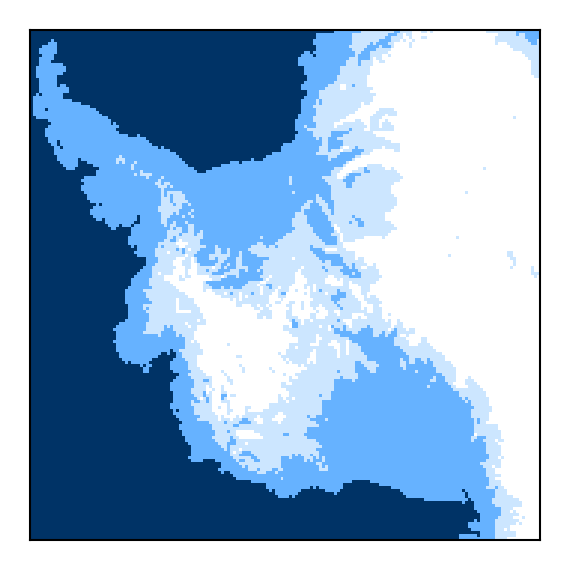

In [23]:
fig, _ = plot_icy(data)
fig.savefig("./results/Potts-data-ice-bedsheet-image.pdf", format="pdf", bbox_inches='tight')

# Helpers

In [5]:
def plot_posterior_comparison(
    mcmc_samples_pl,
    mcmc_samples_auxMCMC,
    mcmc_samples_DFD,
    exact_means,
    exact_vars,
    labels=None,
    bins=60,
    alpha_hist=0.4,
    figsize=(4,2),
):
    """
    Compare the MCMC posterior (histogram) against one or more exact Normal posteriors,
    with a shaded vertical band (e.g., DMH interval).
    """

    if len(exact_means) != len(exact_vars):
        raise ValueError("exact_means and exact_vars must have the same length.")
    if labels is not None and len(labels) != len(exact_means):
        raise ValueError("labels must have same length as exact_means and exact_vars.")

    # Range of x for all distributions
    x_min = 1.1
    x_max = 1.6
    x = np.linspace(x_min, x_max, 600)

    fig, ax = plt.subplots(figsize=figsize)

    # --- Shaded vertical band (DMH) ---
    ax.hist(
        mcmc_samples_auxMCMC,
        bins=bins,
        density=True,
        color="darkviolet",
        histtype='step',
        alpha=0.8,
        label="MCMC-Aux"
    )

    # --- Normalized histogram for MCMC samples ---
    ax.hist(
        mcmc_samples_pl,
        bins=bins,
        density=True,
        histtype='step',
        color="orange",
        alpha=alpha_hist,
        label="PL",
        #edgecolor="",
    )

    ax.hist(
        mcmc_samples_DFD,
        bins=bins,
        density=True,
        histtype='step',
        color="green",
        alpha=alpha_hist,
        label="DFD",
        #edgecolor="",
    )

    # --- Exact Normal posteriors ---
    for i, (mu, var) in enumerate(zip(exact_means, exact_vars)):
        sigma = np.sqrt(var)
        y = norm.pdf(x, loc=mu, scale=sigma)
        lbl = labels[i]
        ax.plot(x, y, lw=2, label=lbl, color='cornflowerblue')

    ax.legend(fontsize=9)

    ax.tick_params(axis='both', labelsize=10)

    ax.set_xlabel(r"$\theta$", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    
    fig.tight_layout()

    return fig, ax


# Config

In [6]:
prior_mean = 0.0
prior_var = 10.0

## Exchange MCMC

In [7]:

# ---------- Utilities ---------- #

def ensure_contiguous_labels(x):
    vals = np.unique(x)
    mapping = {v: i for i, v in enumerate(vals)}
    out = np.empty_like(x, dtype=np.int32)
    for v, i in mapping.items():
        out[x == v] = i
    return out, mapping


def potts_U(labels: np.ndarray, boundary: str = "free") -> int:
    """
    Undirected edge agreements (right + down) counted once.
    4-neighbor grid, consistent with Swendsen–Wang below.
    """
    x = labels
    if boundary == "torus":
        right = (x == np.roll(x, -1, axis=1)).sum()
        down  = (x == np.roll(x, -1, axis=0)).sum()
    elif boundary == "free":
        right = (x[:, :-1] == x[:, 1:]).sum()
        down  = (x[:-1, :] == x[1:, :]).sum()
    else:
        raise ValueError("boundary must be 'free' or 'torus'")
    return int(right + down)


# ---------- Swendsen–Wang sampler ---------- #

class UnionFind:
    __slots__ = ("parent", "rank")
    def __init__(self, n):
        self.parent = np.arange(n, dtype=np.int32)
        self.rank = np.zeros(n, dtype=np.int8)
    def find(self, a):
        p = self.parent
        while p[a] != a:
            p[a] = p[p[a]]
            a = p[a]
        return a
    def union(self, a, b):
        pa, pb = self.find(a), self.find(b)
        if pa == pb: return
        ra, rb = self.rank[pa], self.rank[pb]
        if ra < rb:
            self.parent[pa] = pb
        elif ra > rb:
            self.parent[pb] = pa
        else:
            self.parent[pb] = pa
            self.rank[pa] = ra + 1


def sw_sweep(labels: np.ndarray, beta: float, q: int, boundary: str, rng: np.random.Generator):
    """One Swendsen-Wang sweep."""
    x = labels
    H, W = x.shape
    N = H * W
    uf = UnionFind(N)
    p_bond = 1.0 - np.exp(-beta)

    # --- right bonds ---
    if boundary == "torus":
        same_right = (x == np.roll(x, -1, axis=1))
        active_right = same_right & (rng.random((H, W)) < p_bond)
        rows, cols = np.nonzero(active_right)
        i = rows * W + cols
        j = rows * W + ((cols + 1) % W)
        for a, b in zip(i, j):
            uf.union(a, b)

        # --- down bonds ---
        same_down = (x == np.roll(x, -1, axis=0))
        active_down = same_down & (rng.random((H, W)) < p_bond)
        rows, cols = np.nonzero(active_down)
        i = rows * W + cols
        j = ((rows + 1) % H) * W + cols
        for a, b in zip(i, j):
            uf.union(a, b)

    elif boundary == "free":
        same_right = (x[:, :-1] == x[:, 1:])
        active_right = same_right & (rng.random((H, W - 1)) < p_bond)
        rows, cols = np.nonzero(active_right)
        i = rows * W + cols
        j = rows * W + (cols + 1)
        for a, b in zip(i, j):
            uf.union(a, b)

        same_down = (x[:-1, :] == x[1:, :])
        active_down = same_down & (rng.random((H - 1, W)) < p_bond)
        rows, cols = np.nonzero(active_down)
        i = rows * W + cols
        j = (rows + 1) * W + cols
        for a, b in zip(i, j):
            uf.union(a, b)
    else:
        raise ValueError("boundary must be 'free' or 'torus'")

    # --- relabel clusters ---
    idx = np.arange(N, dtype=np.int32)
    roots = np.fromiter((uf.find(a) for a in idx), dtype=np.int32, count=N)
    uniq, inv = np.unique(roots, return_inverse=True)
    new_colors = rng.integers(0, q, size=uniq.shape[0], dtype=np.int32)
    return new_colors[inv].reshape(H, W)


def simulate_potts_sw(init, beta, q, sweeps, boundary="free", rng=None):
    """Multiple SW sweeps."""
    if rng is None:
        rng = np.random.default_rng()
    x = init.copy()
    for _ in range(sweeps):
        x = sw_sweep(x, beta, q, boundary, rng)
    return x


# ---------- Exchange MCMC ---------- #

def log_prior_normal(beta, mu=0.0, sd=1.0):
    return -0.5 * ((beta - mu) / sd) ** 2  # const ignored


def exchange_mcmc_beta_normal(
    data,
    ncolor,
    n_iter=2000,
    beta_init=1.0,
    prop_sd=0.05,
    prior_mu=0.0,
    prior_sd=1.0,
    boundary="free",
    aux_sweeps=50,
    seed=123,
    reuse_aux=True,
    report_every=100,
):
    """
    Exchange MCMC for 1-parameter Potts model with Normal prior.
    Includes tqdm progress and live acceptance/mean diagnostics.
    """
    rng = np.random.default_rng(seed)
    x_obs, _ = ensure_contiguous_labels(data)
    q = int(ncolor)
    Ux = potts_U(x_obs, boundary)

    betas = np.empty(n_iter)
    beta = float(beta_init)
    logp = log_prior_normal(beta, prior_mu, prior_sd)
    acc = 0

    y_aux = x_obs.copy()

    for t in tqdm(range(n_iter), desc="Exchange MCMC", ncols=80):
        # propose new beta
        beta_prop = beta + rng.normal(0, prop_sd)
        if beta_prop < 0:
            beta_prop = -beta_prop

        # auxiliary sample at proposed beta
        init_y = y_aux if reuse_aux else x_obs
        y_aux = simulate_potts_sw(init_y, beta_prop, q, aux_sweeps, boundary, rng)
        Uy = potts_U(y_aux, boundary)

        logp_prop = log_prior_normal(beta_prop, prior_mu, prior_sd)
        log_alpha = (logp_prop - logp) + (beta_prop - beta) * (Ux - Uy)

        if np.log(rng.random()) < log_alpha:
            beta, logp = beta_prop, logp_prop
            acc += 1

        betas[t] = beta

        if (t + 1) % report_every == 0:
            post_mean = betas[: t + 1].mean()
            acc_rate = acc / (t + 1)
            print(f"[iter {t+1:4d}] mean β = {post_mean:.3f}, acc = {acc_rate:.2f}")

    return betas, acc / n_iter


In [8]:
#RUN only if needed! (Aux MCMC)

"""boundary = "torus"
samples, acc = exchange_mcmc_beta_normal(
    data,
    ncolor=4,
    n_iter=2000,
    beta_init=1.3,
    prop_sd=0.03,
    prior_mu=prior_mean,
    prior_sd=np.sqrt(prior_var),
    boundary=boundary,
    aux_sweeps=30,
    seed=777,
    reuse_aux=True,
)
print("Final acceptance:", acc)
print("Posterior mean:", samples.mean())
np.savetxt("Aux-MCMC-samples.txt", samples)
"""

'boundary = "torus"\nsamples, acc = exchange_mcmc_beta_normal(\n    data,\n    ncolor=4,\n    n_iter=2000,\n    beta_init=1.3,\n    prop_sd=0.03,\n    prior_mu=prior_mean,\n    prior_sd=np.sqrt(prior_var),\n    boundary=boundary,\n    aux_sweeps=30,\n    seed=777,\n    reuse_aux=True,\n)\nprint("Final acceptance:", acc)\nprint("Posterior mean:", samples.mean())\nnp.savetxt("Aux-MCMC-samples.txt", samples)\n'

In [10]:
AuxMCMC_samples = np.loadtxt("./outputs/Aux-MCMC-samples.txt")

## DFD-Bayes

In [ ]:
# =======================
# --- Potts helpers ---
# =======================

def get_neighbors(grid, i, j):
    nrow, ncol = grid.shape
    top    = grid[(i - 1) % nrow, j]
    bottom = grid[(i + 1) % nrow, j]
    left   = grid[i, (j - 1) % ncol]
    right  = grid[i, (j + 1) % ncol]
    return np.array([top, bottom, left, right], dtype=grid.dtype)

def energy(spin, neighbors, beta):
    same_count = np.count_nonzero(neighbors == spin)
    return -beta * same_count

# =======================
# --- log-posterior ---
# =======================

def log_posterior_theta(theta, grid, beta=1.0, prior_mu=0.0, prior_var=10.0):
    """
    theta: scalar parameter (passed directly as β to DSM)
    grid: observed Potts configuration
    beta: loss scaling factor in exp(-β * DSM(θ))
    prior_mu, prior_var: Normal(μ, var) prior on θ
    """
    dsm_val = DSM({"beta": float(theta)}, grid)
    log_like = -beta * dsm_val
    log_prior = -0.5 * ((theta - prior_mu) ** 2) / prior_var
    return log_like - log_prior


def DSM(params, grid, weights=None):
    beta = float(params["beta"])
    q = int(np.max(grid))  # labels are 1..q

    # neighbors (match get_neighbors exactly):
    # top(i,j)    = grid[(i-1)%n, j]    -> roll +1 on axis 0
    # bottom(i,j) = grid[(i+1)%n, j]    -> roll -1 on axis 0
    # left(i,j)   = grid[i, (j-1)%m]    -> roll +1 on axis 1
    # right(i,j)  = grid[i, (j+1)%m]    -> roll -1 on axis 1
    top    = np.roll(grid,  +1, axis=0)
    bottom = np.roll(grid,  -1, axis=0)
    left   = np.roll(grid,  +1, axis=1)
    right  = np.roll(grid,  -1, axis=1)

    # counts of matching neighbors for current spin
    same = (
        (grid == top).astype(np.int8) +
        (grid == bottom).astype(np.int8) +
        (grid == left).astype(np.int8) +
        (grid == right).astype(np.int8)
    ).astype(np.float64)

    # cyclic predecessor/successor on {1,...,q}
    x_minus = 1 + ((grid - 2) % q)
    x_plus  = 1 + (grid % q)

    # counts if flipped to predecessor / successor
    same_minus = (
        (x_minus == top).astype(np.int8) +
        (x_minus == bottom).astype(np.int8) +
        (x_minus == left).astype(np.int8) +
        (x_minus == right).astype(np.int8)
    ).astype(np.float64)

    same_plus = (
        (x_plus == top).astype(np.int8) +
        (x_plus == bottom).astype(np.int8) +
        (x_plus == left).astype(np.int8) +
        (x_plus == right).astype(np.int8)
    ).astype(np.float64)

    # log-unnormalized masses (log p ∝ beta * same_count)
    logp       = beta * same
    logp_minus = beta * same_minus
    logp_plus  = beta * same_plus

    # exact asymmetric DFD term (same as your loop)
    term = np.exp(2.0 * (logp_minus - logp)) - 2.0 * np.exp(logp - logp_plus)

    if weights is None:
        # identical to your original (unweighted) mean
        return float(term.mean(dtype=np.float64))

    # weighted mean to emulate bootstrap weights
    w = np.asarray(weights)
    if w.shape == ():
        # scalar weight -> broadcast
        w = np.full(grid.shape, float(w), dtype=np.float64)
    elif w.shape != grid.shape:
        raise ValueError(f"`weights` must be scalar or shape {grid.shape}, got {w.shape}")

    w = w.astype(np.float64, copy=False)
    num = np.sum(term * w, dtype=np.float64)
    den = np.sum(w, dtype=np.float64)
    if den == 0.0:
        raise ValueError("Sum of weights is zero.")
    return float(num / den)



# =======================
# --- MCMC Sampler ---
# =======================

def sample_theta_mcmc(
    grid,
    n_samples=5000,
    init_theta=0.0,
    proposal_sd=0.1,
    burn_in=1000,
    thin=1,
    beta=1.0,           # scaling factor in exp(-β * DSM(θ))
    prior_mu=0.0,       # prior mean
    prior_var=10.0,     # prior variance
    rng=None,
    return_trace=False,
):
    """
    Random-walk Metropolis sampler for:
        p(θ) ∝ exp(-β * DSM(θ)) * N(μ, var)
    """
    if rng is None:
        rng = np.random.default_rng()

    total_iters = burn_in + n_samples * thin
    theta = float(init_theta)

    samples = np.empty(n_samples, dtype=float)
    accepts = 0

    if return_trace:
        theta_trace = np.empty(total_iters, dtype=float)
        lp_trace = np.empty(total_iters, dtype=float)

    # initial log posterior
    cur_lp = log_posterior_theta(theta, grid, beta=beta, prior_mu=prior_mu, prior_var=prior_var)

    kept = 0
    for it in trange(total_iters, desc="MCMC sampling", unit="iter"):
        # propose θ' ~ N(θ, proposal_sd²)
        prop = theta + rng.normal(0.0, proposal_sd)
        prop_lp = log_posterior_theta(prop, grid, beta=beta, prior_mu=prior_mu, prior_var=prior_var)

        # MH acceptance
        log_alpha = prop_lp - cur_lp
        if np.log(rng.uniform()) < log_alpha:
            theta = prop
            cur_lp = prop_lp
            if it >= burn_in:
                accepts += 1

        # record
        if return_trace:
            theta_trace[it] = theta
            lp_trace[it] = cur_lp

        # store thinned sample
        if it >= burn_in and ((it - burn_in) % thin == 0):
            samples[kept] = theta
            kept += 1

    acc_rate = accepts / n_samples
    info = {
        "accept_rate": acc_rate,
        "proposal_sd": proposal_sd,
        "loss_scale": beta,
        "prior_mu": prior_mu,
        "prior_var": prior_var,
    }
    if return_trace:
        info["theta_trace"] = theta_trace
        info["logpost_trace"] = lp_trace

    return samples, info


def posterior_bootstrap_calibration_beta(
    grid,
    dsm_estimate,                # your point estimate to test
    loss_scale_beta,         # the fixed beta in exp(-beta * DSM(theta; w))
    B=200,
    ci_level=0.95,
    rng=None,
    # MCMC settings (same semantics as your sampler)
    n_samples=1000,
    burn_in=2000,
    proposal_sd=0.1,
    thin=1,
    init_theta=1.4,
    prior_mu=0.0,
    prior_var=10.0,
):
    """
    Posterior-bootstrap calibration for a fixed loss-scale 'loss_scale_beta'.
    Uses Poisson(1) weights to reweight DSM. Progress shown with tqdm.
    Returns (freq_in, intervals, accept_rates).
    """
    if rng is None:
        rng = np.random.default_rng()

    def logpost_weighted(theta, w):
        dsm_val = DSM({"beta": float(theta)}, grid, weights=w)
        log_like = -loss_scale_beta * dsm_val
        log_prior = -0.5 * ((theta - prior_mu) ** 2) / prior_var
        return log_like - log_prior

    def run_chain_with_weights(w):
        total_iters = burn_in + n_samples * thin
        theta = float(init_theta)
        samples = np.empty(n_samples, dtype=float)
        accepts = 0

        cur_lp = logpost_weighted(theta, w)
        kept = 0
        for it in range(total_iters):
            prop = theta + rng.normal(0.0, proposal_sd)
            prop_lp = logpost_weighted(prop, w)
            if np.log(rng.uniform()) < (prop_lp - cur_lp):
                theta, cur_lp = prop, prop_lp
                if it >= burn_in:
                    accepts += 1
            if it >= burn_in and ((it - burn_in) % thin == 0):
                samples[kept] = theta
                kept += 1
        return samples, accepts / n_samples

    def equal_tailed_ci(samples, level=0.95):
        a = (1.0 - level) / 2.0
        return float(np.quantile(samples, a)), float(np.quantile(samples, 1 - a))

    intervals = []
    accept_rates = []
    inside = 0

    for _ in trange(B, desc="Posterior bootstrap", unit="boot"):
        # Poisson(1) bootstrap weights
        w = rng.poisson(1.0, size=grid.shape).astype(np.float64)
        if w.sum() == 0:
            w.flat[0] = 1.0

        samp, acc = run_chain_with_weights(w)
        lo, hi = equal_tailed_ci(samp, level=ci_level)
        intervals.append((lo, hi))
        accept_rates.append(acc)
        if lo <= dsm_estimate <= hi:
            inside += 1

    freq_in = inside / B
    return freq_in, intervals, accept_rates


In [25]:
def fit_DSM(grid, theta_bounds=(-10.0, 10.0)):

    def objective_theta(theta):
        beta = np.exp(theta)
        return DSM({"beta": beta}, grid)

    res = minimize_scalar(objective_theta, bounds=theta_bounds, method="bounded")
    theta_hat = float(np.exp(res.x))
    return theta_hat, res

In [26]:
RUN = False
if RUN:
    beta_DFD = 0.08 #estmated from below procedure
    dsm_estimate, res = fit_DSM(data)
    
    freq_in, intervals, accs = posterior_bootstrap_calibration_beta(
        data,
        dsm_estimate=dsm_estimate,          # your unweighted DSM estimate
        loss_scale_beta=beta_DFD,        # fixed beta in your log posterior
        B=50,
        ci_level=0.95,
        n_samples=500,
        burn_in=100,
        proposal_sd=0.1,
        thin=1,
        init_theta=1.4,
        prior_mu=0.0,
        prior_var=10.0,
        rng=np.random.default_rng(42),
    )
    print(f"Calibration frequency at beta={beta_DFD}: {freq_in:.3f}")
    print(f"Median accept rate: {np.median(accs):.3f}")

In [27]:
if RUN:
    DFD_samples, info = sample_theta_mcmc(
        data,
        init_theta=1.4,
        n_samples=2000,
        burn_in=500,
        proposal_sd=0.1,
        beta=beta_DFD,
        prior_mu=0.0,
        prior_var=10.0,
        return_trace=False,
    )

    print("Acceptance rate:", info["accept_rate"])
    np.savetxt("DFD_samples.txt", DFD_samples, fmt="%.6f")
else:
    DFD_samples = np.loadtxt("./outputs/DFD_samples.txt")

(array([  8.,  34.,  53., 131., 337., 502., 436., 354., 118.,  27.]),
 array([1.35607 , 1.379101, 1.402132, 1.425163, 1.448194, 1.471225,
        1.494256, 1.517287, 1.540318, 1.563349, 1.58638 ]),
 <BarContainer object of 10 artists>)

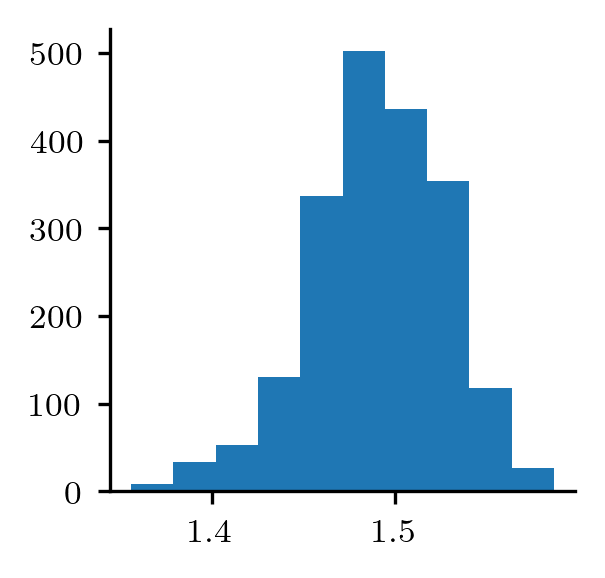

In [28]:
plt.figure(figsize=(2,2))
plt.hist(DFD_samples)

# PL 

In [31]:
@dataclass
class PLConfig:
    n_samples: int = 3000
    burn_in: int = 1000
    thin: int = 1
    proposal_std_beta: float = 0.05
    normal_mu: float = 0.0
    normal_sigma: float = 1.0
    init_beta: float = 0.3
    random_seed: int | None = 1234


def _neighbor_counts_4(grid, Xi):
    """
    For each site and each state in Xi, count 4-neighbor matches via convolution.
    Returns a (N, q) integer array where q = len(Xi), N = L*L.
    """
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    masks = np.array([grid == s for s in Xi])  # (q, L, M)
    counts = np.array([convolve(mask.astype(int), kernel, mode='wrap') for mask in masks])  # (q, L, M)
    return counts.reshape(len(Xi), -1).T  # (N, q)


def _logsumexp_rows(M: np.ndarray) -> np.ndarray:
    m = M.max(axis=1, keepdims=True)
    return (m + np.log(np.exp(M - m).sum(axis=1, keepdims=True))).ravel()


def _log_pseudo_lik(grid: np.ndarray, Xi: np.ndarray, beta: float,
                    ncnt: np.ndarray, cidx: np.ndarray) -> float:
    M = beta * ncnt                        # (N, q)
    A = _logsumexp_rows(M)                 # log sum_s exp(β m_{i,s})
    B = beta * ncnt[np.arange(ncnt.shape[0]), cidx]
    return float(np.sum(B - A))            # <-- TRUE log PL (not NLL)


def pl_mcmc_beta(grid: np.ndarray, config: PLConfig):
    """
    Random-walk MH on beta targeting PL(beta|x) * Normal(beta | mu, sigma^2).
    """
    rng = np.random.default_rng(config.random_seed)
    grid = np.asarray(grid)
    Xi = np.unique(grid)
    q  = len(Xi)

    # Precompute sufficient pieces for PL
    ncnt = _neighbor_counts_4(grid, Xi)                   # (N, q)
    cidx = np.searchsorted(Xi, grid.ravel()).astype(int)  # (N,)

    # Init
    beta_curr = float(config.init_beta)
    logpl_curr = _log_pseudo_lik(grid, Xi, beta_curr, ncnt, cidx)
    logpr_curr = log_prior_normal(beta_curr, config.normal_mu, config.normal_sigma)

    n_keep = config.n_samples
    total_iters = config.burn_in + n_keep * config.thin

    store = np.empty(n_keep, dtype=float)

    n_keep = config.n_samples
    total_iters = config.burn_in + n_keep * config.thin

    accepts = 0
    kept = 0

    for it in range(total_iters):
        # propose β'
        beta_prop = beta_curr + rng.normal(0.0, config.proposal_std_beta)

        # log posterior pieces
        logpl_prop = _log_pseudo_lik(grid, Xi, beta_prop, ncnt, cidx)
        logpr_prop = log_prior_normal(beta_prop, config.normal_mu, config.normal_sigma)

        # symmetric proposal -> MH log-accept
        log_acc = (logpl_prop + logpr_prop) - (logpl_curr + logpr_curr)

        if np.log(rng.uniform()) < log_acc:
            beta_curr  = beta_prop
            logpl_curr = logpl_prop
            logpr_curr = logpr_prop

            if it >= config.burn_in:
                accepts += 1

        if it >= config.burn_in and ((it - config.burn_in) % config.thin == 0):
            store[kept] = beta_curr
            kept += 1
            if kept >= n_keep:
                break

    n_trials_postburn = total_iters - config.burn_in
    accept_rate = accepts / max(1, n_trials_postburn)

    stats = {
        "q": q,
        "n_trials_postburn": n_keep,
        "burn_in": config.burn_in,
        "thin": config.thin,
        "proposal_std_beta": config.proposal_std_beta,
        "prior": {"type": "normal", "mu": config.normal_mu, "sigma": config.normal_sigma},
        "accept_rate": accept_rate,
    }
    return store, stats

In [32]:
cfg_pl = PLConfig(
    n_samples=2_000, burn_in=500, thin=2,
    proposal_std_beta=0.08,
    normal_mu=prior_mean, normal_sigma=np.sqrt(prior_var),
    init_beta=1.2, random_seed=123
)

post_beta_pl, stats_pl = pl_mcmc_beta(data, cfg_pl)
print("accept:", stats_pl["accept_rate"])
print("mean β:", np.mean(post_beta_pl))

accept: 0.247
mean β: 1.5070932264909866


## LRM

In [33]:
emp = EmpiricalPottsConditional(grid=data, alpha=1.0)
summary = emp.summarize_conditionals(quantiles=(0.01, 0.02, 0.05, 0.1))

Summary of q(s | neighbors):
    min: 0.000108
   q01: 0.000166
   q02: 0.004237
   q05: 0.005799
   q10: 0.007013
 median: 0.166667
    max: 0.999677
   mean: 0.250000


In [34]:
post_means = []
post_vars = []
alpha_vals = [1.0]
#eps_vals = [1e-6, 0.0007, 0.003, 0.006]
eps_vals = [summary[0.05]] #q05 (see below)
for (eps, alpha) in zip(eps_vals, alpha_vals):
    lrm = PottsModel(data, alpha=alpha, log_eps=np.log(eps))
    beta_star, cov_star, res = lrm.fit_coverage(prior_mean, prior_var=prior_var, beta_high=1., B=50)
    print("beta *: {}, cov *: {}".format(beta_star, cov_star))
    post_mean, post_var =lrm.posterior(beta=beta_star, prior_mean=prior_mean, prior_var=prior_var)
    post_means.append(post_mean)
    post_vars.append(post_var)

beta *: 0.004994463883440386, cov *: 0.98


## Results

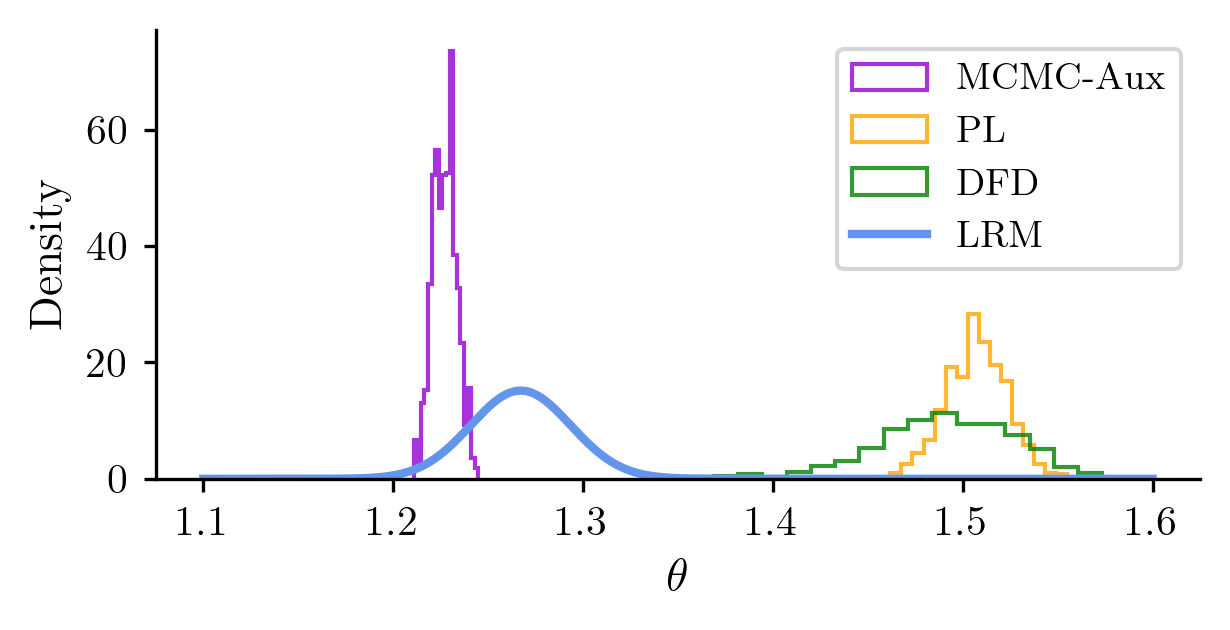

In [ ]:
fig, ax = plot_posterior_comparison(post_beta_pl,
                          AuxMCMC_samples[500:],
                          DFD_samples,
                          exact_means=post_means,
                          exact_vars=post_vars,
                          figsize=(4.2,2.2),
                          labels=["LRM"],
                          bins=18,
                          alpha_hist=.8
                          )
#fig.savefig("./results/bedmap-exp-lrm-fit.pdf",  format='pdf', bbox_inches='tight')